In [1]:
import numpy as np
import pandas as pd
import pyreadr
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

from natsort import natsorted
from glob import glob
import pickle
import os
from os.path import basename, splitext
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from scipy.stats import multivariate_normal
from statsmodels.stats.multitest import multipletests
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
pd.set_option('display.max_columns', 40)
sns.set_theme(context='notebook', style='ticks')

from utils.shift import *
from utils.age import *
from utils.vis import plot_performance_scatter, plot_repr_uncertainty, plot_covariate_panel

%load_ext autoreload
%autoreload 2

#load published mouse clocks
clocks = pickle.load(open('subdata/clock_coefs_mouse.pkl', 'rb'))
cname = 'Thompson'
clock = clocks[cname]

# GSE120132 <-> GSE121141 (Aging liver: Thompson - Meer)

In [2]:
#Aging (Thompson) https://www.aging-us.com/article/101590/text
dfa, meta = pd.read_pickle('datasets/GSE120132.pkl').values()
dfa = dfa.loc[meta.index]

#Aging (Meer)
dfr, metr = pd.read_pickle('datasets/GSE121141.pkl').values()
dfr = dfr.loc[metr.index]

tissue_age = 'Liver'

if tissue_age is not None:
    meta = meta[meta['Tissue'] == tissue_age]
    dfa = dfa.loc[meta.index].dropna(axis=1)
    metr = metr[metr['Tissue'] == tissue_age]
    dfr = dfr.loc[metr.index].dropna(axis=1)

print('Age 1, N sites', len(dfa.columns))
print('Age 2, N sites', len(dfr.columns))

Age 1, N sites 1113442
Age 2, N sites 1351293


## Check covariate shift

In [3]:
sites = clock.index.intersection(dfr.columns).intersection(dfa.columns)
print(f"{len(sites)} common sites")

Xa_clock = dfa[sites]
Xr_clock = dfr[sites]

ya = meta['Age']
yr = metr['Age']

300 common sites


98.67% of sites are not rejected by KS test


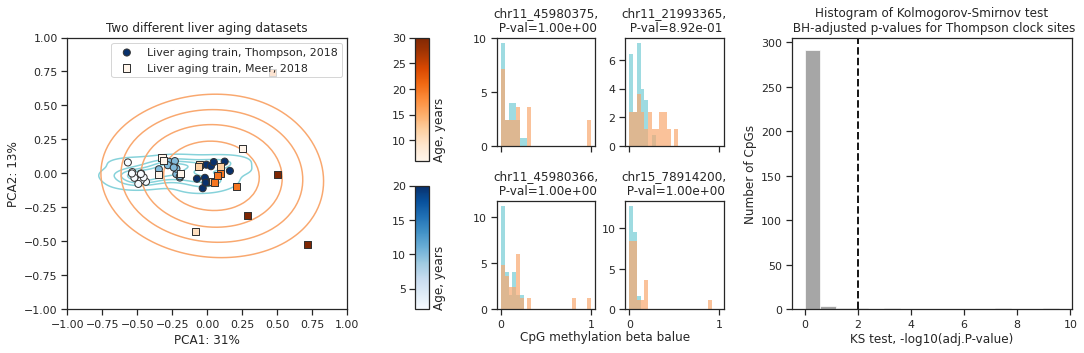

In [4]:
plot_covariate_panel(Xa_clock, Xr_clock, ya, yr,
                        cbar_color_train = 'Blues',
                        cbar_color_test = 'Oranges',
                        color_train = '#86d2da',
                        color_test = '#f9a86f',
                        xa_thr=0.05,
                        xr_thr=0.5,
                        cbar_label_train = 'Age, years',
                        cbar_label_test = 'Age, years',
                        legend_label_train = 'Liver aging train, Thompson, 2018',
                        legend_label_test ='Liver aging train, Meer, 2018',
                        ks_hist_title = 'Histogram of Kolmogorov-Smirnov test\n BH-adjusted p-values for Thompson clock sites',
                        pca_title = 'Two different liver aging datasets',
                        pca_legend_pos = 'upper right',
                        pca_xlim = [-1, 1.0], #pca_xlim = [-2.7, 5.0],
                        pca_ylim = [-1, 1.0]  #pca_ylim = [-1.5, 5.0]                   
                        )

plt.savefig('figs/A1_sup_aging_liver.pdf', format='pdf', bbox_inches='tight')
plt.show()

## Inversed Train Test Procedure (ITTP)

In [5]:
# Thompson clocks
sites = clock.index.intersection(dfr.columns).intersection(dfa.columns)
print(f"{len(sites)} common sites")

Xa_clock = dfa[sites]
Xr_clock = dfr[sites]

ya = meta['Age']
yr = metr['Age']

300 common sites


Step 1 results:
R2 train = 0.992
MAE train = 0.575
R2 test = -0.804
MAE test = 7.357
------------------------------
Step 2 results:
R2 train = -0.8
MAE train = 7.336
R2 test = 0.955
MAE test = 1.234
------------------------------


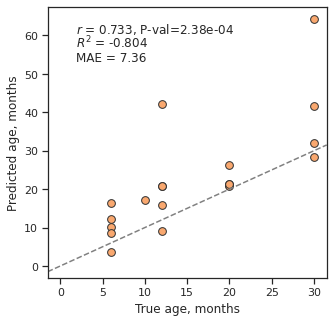

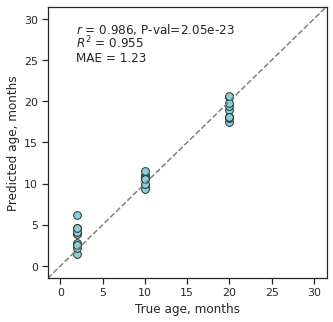

In [6]:
# Thompson -> Meer
from warnings import filterwarnings
filterwarnings('ignore')
from sklearn.linear_model import LassoCV
(y_train_predict_step1, 
 y_test_predict_step1, 
 y_train_predict_step2,
 y_test_predict_step2) = inverse_train_test_procedure(LassoCV, 
                                 Xa_clock, ya, 
                                 Xr_clock, y_test=yr, 
                                 params={"max_iter":3000},
                                 verbose=0)

plot_performance_scatter(yr, y_test_predict_step1, eq_bounds=(0, 30), color='#f9a86f', markersize=60, units='months')
plt.savefig('figs/A3_aging_liver_thompson_meer_step1.pdf', format='pdf', bbox_inches='tight')
plt.show()

plot_performance_scatter(ya, y_test_predict_step2, eq_bounds=(0, 30), color='#86d2da', markersize=60, units='months')
plt.savefig('figs/A3_aging_liver_thompson_meer_step2.pdf', format='pdf', bbox_inches='tight')
plt.show()

Step 1 results:
R2 train = 1.0
MAE train = 0.041
R2 test = 0.511
MAE test = 3.931
------------------------------
Step 2 results:
R2 train = 0.509
MAE train = 3.915
R2 test = 0.806
MAE test = 2.483
------------------------------


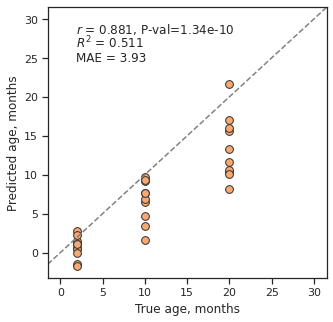

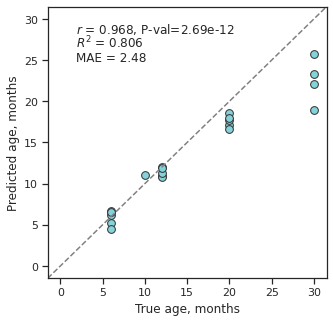

In [7]:
# Meer -> Thompson
(y_train_predict_step1, 
 y_test_predict_step1, 
 y_train_predict_step2,
 y_test_predict_step2) = inverse_train_test_procedure(LassoCV, 
                                 Xr_clock, yr, 
                                 Xa_clock, y_test=ya, 
                                 params={"max_iter":3000},
                                 verbose=0)

plot_performance_scatter(ya, y_test_predict_step1, eq_bounds=(0, 30), color='#f9a86f', markersize=60, units='months')
plt.savefig('figs/A3_aging_liver_meer_thompson_step1.pdf', format='pdf', bbox_inches='tight')
plt.show()

plot_performance_scatter(yr, y_test_predict_step2, eq_bounds=(0, 30), color='#86d2da', markersize=60, units='months')
plt.savefig('figs/A3_aging_liver_meer_thompson_step2.pdf', format='pdf', bbox_inches='tight')
plt.show()

## Epistemic uncertainty estimation with Gaussian Process Regressor

### Thompson -> Meer

300 common sites
R2 train = 0.9999889866946264
R2 test = 0.821835408710513
MAE train = 0.018934767233893333
MAE test = 3.014682873611811
------------------------------
Resulting kernel: 16.4**2 * RBF(length_scale=2.99) + WhiteKernel(noise_level=0.1)


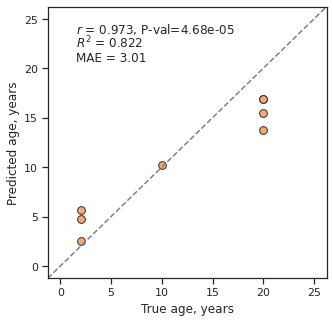

In [8]:
sites = clock.index.intersection(dfr.columns).intersection(dfa.columns)
print(f"{len(sites)} common sites")

Xa_clock = dfa[sites]
Xr_clock = dfr[sites]

ya = meta['Age']
yr = metr['Age']

X_train, X_test, y_train, y_test = train_test_split(Xa_clock, ya, test_size=0.25, random_state=10)


### TRAINING ###
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF

# kernel = 1 * DotProduct(sigma_0=1, sigma_0_bounds=(1e-2, 100)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-1, 100))
kernel = 1 * RBF(length_scale=1, length_scale_bounds=(1e-2, 100)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-1, 100))
         
model = GaussianProcessRegressor(kernel=kernel, normalize_y=False, n_restarts_optimizer=3)
model.fit(X_train, y_train)

y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

print(f'R2 train = {r2_score(y_train, y_train_predict)}')
print(f'R2 test = {r2_score(y_test, y_test_predict)}')
print(f'MAE train = {mean_absolute_error(y_train, y_train_predict)}')
print(f'MAE test = {mean_absolute_error(y_test, y_test_predict)}')
print('-'*30)
print("Resulting kernel:", model.kernel_)

plot_performance_scatter(y_test, y_test_predict, eq_bounds=(0, 25), color='#f9a86f', markersize=60)

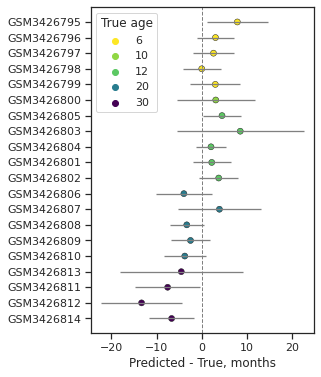

R2 test = 0.6108428706489649
MAE test = 4.516488501869267


In [9]:
import matplotlib as mpl
import matplotlib.cm as cm

#prediction of test dataset
y_test_predict_r, y_test_std_r = model.predict(Xr_clock, return_std=True)

metr['gpr_age'] = y_test_predict_r
metr['gpr_std'] = y_test_std_r
metr['diff'] = metr['gpr_age'] - metr['Age']
   
fig, ax = plt.subplots(1,1, figsize=(4, 6))
metr_ = metr.copy().reset_index().sort_values('Age')

sns.scatterplot(
    data=metr_, x="diff", y='index',  
    marker="o",
    hue='Age',
    edgecolor='k',
    palette=mpl.cm.viridis_r,
    ax=ax
)

ax.errorbar(x=metr_['diff'], y=metr_['index'], xerr=metr_['gpr_std'], linewidth=0, elinewidth=1.3, color='grey')
ax.axvline(0, ls='--', lw=1, color='grey')
ax.set_xlabel('Predicted - True, months')
ax.set_ylabel('')
ax.legend(title='True age', loc='upper left')
plt.show()

print(f'R2 test = {r2_score(yr, y_test_predict_r)}')
print(f'MAE test = {mean_absolute_error(yr, y_test_predict_r)}')

### Meer -> Thompson

300 common sites
R2 train = 0.9999984362853912
R2 test = 0.81867669229355
MAE train = 0.009795536103095078
MAE test = 2.8122858665780095
------------------------------
Resulting kernel: 21.1**2 * RBF(length_scale=3.17) + WhiteKernel(noise_level=0.1)


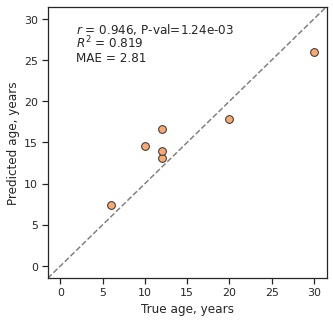

In [10]:
sites = clock.index.intersection(dfr.columns).intersection(dfa.columns)
print(f"{len(sites)} common sites")

Xa_clock = dfa[sites]
Xr_clock = dfr[sites]

ya = meta['Age']
yr = metr['Age']

X_train, X_test, y_train, y_test = train_test_split(Xr_clock, yr, test_size=0.33, random_state=10)


### TRAINING ###
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF

# kernel = 1 * DotProduct(sigma_0=1, sigma_0_bounds=(1e-2, 100)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-1, 100))
kernel = 1 * RBF(length_scale=1, length_scale_bounds=(1e-2, 100)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-1, 100))
         
model = GaussianProcessRegressor(kernel=kernel, normalize_y=False, n_restarts_optimizer=3)
model.fit(X_train, y_train)

y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

print(f'R2 train = {r2_score(y_train, y_train_predict)}')
print(f'R2 test = {r2_score(y_test, y_test_predict)}')
print(f'MAE train = {mean_absolute_error(y_train, y_train_predict)}')
print(f'MAE test = {mean_absolute_error(y_test, y_test_predict)}')
print('-'*30)
print("Resulting kernel:", model.kernel_)

plot_performance_scatter(y_test, y_test_predict, eq_bounds=(0, 30), color='#f9a86f', markersize=60)

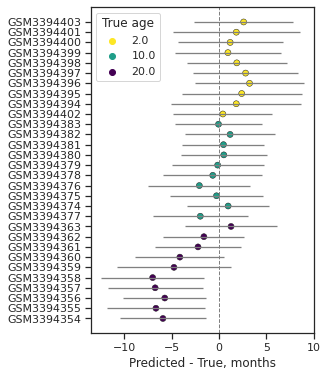

R2 test = 0.8095749385512212
MAE test = 2.4470726178971125


In [11]:
import matplotlib as mpl
import matplotlib.cm as cm

#prediction of test dataset
y_test_predict_r, y_test_std_r = model.predict(Xa_clock, return_std=True)

meta['gpr_age'] = y_test_predict_r
meta['gpr_std'] = y_test_std_r
meta['diff'] = meta['gpr_age'] - meta['Age']
   
fig, ax = plt.subplots(1,1, figsize=(4, 6))
meta_ = meta.copy().reset_index().sort_values('Age')

sns.scatterplot(
    data=meta_, x="diff", y='index',  
    marker="o",
    hue='Age',
    edgecolor='k',
    palette=mpl.cm.viridis_r,
    ax=ax
)

ax.errorbar(x=meta_['diff'], y=meta_['index'], xerr=meta_['gpr_std'], linewidth=0, elinewidth=1.3, color='grey')
ax.axvline(0, ls='--', lw=1, color='grey')
ax.set_xlabel('Predicted - True, months')
ax.set_ylabel('')
ax.legend(title='True age', loc='upper left')
plt.show()

print(f'R2 test = {r2_score(ya, y_test_predict_r)}')
print(f'MAE test = {mean_absolute_error(ya, y_test_predict_r)}')